In [1]:
import os
import json
import csv
from IPython.display import display, clear_output
import ipywidgets as widgets
import subprocess
from pydub import AudioSegment
import openai
from io import BytesIO
import base64
from PIL import Image
import matplotlib.pyplot as plt
import platform
import ast
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [2]:
def load_progress(progress_file):
    if os.path.exists(progress_file):
        try:
            with open(progress_file, "r") as f:
                return json.load(f)
        except json.JSONDecodeError:
            print(f"⚠️ Warning: {progress_file} is empty or corrupted. Starting fresh.")
            return {}
    return {}

def list_videos(folder):
    exts = {".mp4", ".mov", ".avi", ".mkv"}
    videos = []
    for f in os.listdir(folder):
        if os.path.splitext(f)[1].lower() in exts:
            full_path = os.path.abspath(os.path.join(folder, f))
            if os.path.isfile(full_path):
                videos.append(full_path)
    return sorted(videos)

def load_csv_info(csv_path):
    info = {}
    if not os.path.exists(csv_path):
        print(f"⚠️ CSV file not found: {csv_path}")
        return info
    with open(csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            video_name = row.get("video_name")
            if video_name:
                info[video_name] = {
                    "collector_name": row.get("collector_name", ""),
                    "material": row.get("material", ""),
                    "duration": row.get("duration", "")
                }
    return info

def select_next_video_with_info(folder, progress_file, csv_path):
    progress = load_progress(progress_file)
    videos = list_videos(folder)
    csv_info = load_csv_info(csv_path)

    for v in videos:
        if not progress.get(v, False):
            # Extract the filename from full path for matching CSV info
            filename = os.path.basename(v)
            info = csv_info.get(filename, None)
            return v, info
    return None, None

# Usage example:
BASE_DIR = os.getcwd()
PROGRESS_FILE = os.path.abspath(os.path.join(BASE_DIR, "progress.json"))
VIDEOS_FOLDER = "../data/continuous-videos/jiawei_testbed"  # your folder with video files
CSV_PATH = "../data/continuous_videos_clean.csv"

next_video, video_info = select_next_video_with_info(VIDEOS_FOLDER, PROGRESS_FILE, CSV_PATH)

if next_video:
    print("Next video to process:", next_video)
    if video_info:
        print("Video info from CSV:")
        print(f"  Collector Name: {video_info['collector_name']}")
        print(f"  Material: {video_info['material']}")
        print(f"  Duration: {video_info['duration']}")
    else:
        print("No CSV info found for this video.")
else:
    print("🎉 All videos processed!")



Next video to process: /Users/aleksadianka/Desktop/CCNY/SideWALK/algorithms/legacy_sidewalk_data_labelbox/data/continuous-videos/jiawei_testbed/0_2023-08-21 13_05_23.9010_none.MOV
Video info from CSV:
  Collector Name: jiawei_testbed
  Material: none
  Duration: 9.0


In [5]:
# Your existing functions for loading progress, listing videos, and csv info...
# (Assuming they are already defined in the notebook)

def has_audio(video_path):
    cmd = [
        "ffprobe", "-i", video_path,
        "-show_streams", "-select_streams", "a",
        "-loglevel", "error"
    ]
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return bool(result.stdout.strip())

def is_audio_silent(video_path, silence_threshold=-50.0):
    audio = AudioSegment.from_file(video_path)
    return audio.dBFS < silence_threshold

# Select next video
next_video, video_info = select_next_video_with_info(VIDEOS_FOLDER, PROGRESS_FILE, CSV_PATH)

if next_video is None:
    print("🎉 All videos processed!")
else:
    print("Next video to process:", next_video)
    if video_info:
        print(f"Collector: {video_info['collector_name']}")
        print(f"Material: {video_info['material']}")
        print(f"Duration: {video_info['duration']}")
    else:
        print("No CSV info found for this video.")

    # Now check audio presence and silence
    if not has_audio(next_video):
        print("❌ No audio track found.")
    else:
        if is_audio_silent(next_video):
            print("🔇 Audio track is present but silent.")
        else:
            print("🔊 Audio track contains sound.")


Next video to process: /Users/aleksadianka/Desktop/CCNY/SideWALK/algorithms/legacy_sidewalk_data_labelbox/data/continuous-videos/jiawei_testbed/0_2023-08-21 13_05_23.9010_none.MOV
Collector: jiawei_testbed
Material: none
Duration: 9.0
🔊 Audio track contains sound.


In [10]:
def is_segment_silent(audio_segment, silence_threshold=-50.0):
    return audio_segment.dBFS < silence_threshold

def check_silence_edges(video_path, silence_threshold=-50.0, segment_duration_ms=1000):
    audio = AudioSegment.from_file(video_path)
    duration_ms = len(audio)
    if duration_ms < 2 * segment_duration_ms:
        # Video too short to check both ends separately; check whole audio
        return is_segment_silent(audio, silence_threshold), is_segment_silent(audio, silence_threshold)
    
    start_segment = audio[:segment_duration_ms]
    end_segment = audio[-segment_duration_ms:]
    
    start_silent = is_segment_silent(start_segment, silence_threshold)
    end_silent = is_segment_silent(end_segment, silence_threshold)
    
    return start_silent, end_silent

if not has_audio(next_video):
    print("❌ No audio track found.")
else:
    start_silent, end_silent = check_silence_edges(next_video)
    
    if start_silent:
        print("🔇 First 1 second of audio is silent.")
    else:
        print("🔊 First 1 second of audio contains sound.")
        
    if end_silent:
        print("🔇 Last 1 second of audio is silent.")
    else:
        print("🔊 Last 1 second of audio contains sound.")
    
    # Optional: overall silence check too
    if is_audio_silent(next_video):
        print("🔇 Audio track overall is silent.")
    else:
        print("🔊 Audio track overall contains sound.")


🔊 First 1 second of audio contains sound.
🔊 Last 1 second of audio contains sound.
🔊 Audio track overall contains sound.


In [11]:
def open_video_default_player(filepath):
    if not os.path.isfile(filepath):
        print(f"❌ File does not exist: {filepath}")
        return
    
    system = platform.system()
    
    try:
        if system == "Darwin":  # macOS
            subprocess.run(["open", filepath])
        elif system == "Windows":
            os.startfile(filepath)  # only on Windows
        elif system == "Linux":
            subprocess.run(["xdg-open", filepath])
        else:
            print(f"❌ Unsupported OS: {system}")
    except Exception as e:
        print(f"❌ Failed to open video: {e}")
        
open_video_default_player(next_video)

If there is any problem with audio mark video invalid and add reason:

In [11]:
# New button for marking invalid
PROGRESS_FILE = "progress.json"

# Load progress or start fresh
if os.path.exists(PROGRESS_FILE):
    with open(PROGRESS_FILE, "r") as f:
        try:
            progress = json.load(f)
        except json.JSONDecodeError:
            progress = {}
else:
    progress = {}

# UI widgets
btn_mark_invalid = widgets.Button(description="Mark as invalid ❌", button_style="danger")
txt_invalid_reason = widgets.Text(
    placeholder='Enter reason why this video is invalid',
    description='Reason:',
    layout=widgets.Layout(width='100%')
)
btn_mark_done = widgets.Button(description="Mark this video as completed ✅", button_style="success")
lbl_video_path = widgets.HTML()
lbl_completed_list = widgets.HTML()
out_msg = widgets.Output()

# Current video state - set your next video path here manually or from other logic
current_state = {
    "next_video": None,
}

# For demonstration, assign a sample video path
current_state["next_video"] = next_video

# Simple UI refresh to show current video and completed list
def refresh_ui():
    if current_state["next_video"]:
        lbl_video_path.value = f"<b>Current video:</b> {current_state['next_video']}"
    else:
        lbl_video_path.value = "<b>No video selected.</b>"
    
    # Show completed and invalid videos
    completed = []
    invalid = []
    for v, data in progress.items():
        if isinstance(data, dict):
            if data.get("status") == "done":
                completed.append(os.path.basename(v))
            elif data.get("status") == "invalid":
                invalid.append(f"{os.path.basename(v)} (Reason: {data.get('reason', 'No reason')})")
        elif data is True:
            completed.append(os.path.basename(v))
    html_parts = []
    if completed:
        html_parts.append("<b>Completed videos:</b><ul>" + "".join(f"<li>{v}</li>" for v in completed) + "</ul>")
    if invalid:
        html_parts.append("<b>Invalid videos:</b><ul>" + "".join(f"<li>{v}</li>" for v in invalid) + "</ul>")
    if not html_parts:
        lbl_completed_list.value = "<i>No videos processed yet.</i>"
    else:
        lbl_completed_list.value = "".join(html_parts)

    with out_msg:
        out_msg.clear_output()

def mark_invalid_clicked(b):
    if current_state["next_video"]:
        reason = txt_invalid_reason.value.strip()
        if not reason:
            with out_msg:
                out_msg.clear_output()
                print("⚠️ Please enter a reason for marking invalid.")
            return

        norm_video = os.path.normpath(current_state["next_video"])
        progress[norm_video] = {
            "status": "invalid",
            "reason": reason
        }
        with open(PROGRESS_FILE, "w") as f:
            json.dump(progress, f, indent=2)

        with out_msg:
            out_msg.clear_output()
            print(f"Marked invalid: {norm_video}")
            print(f"Reason: {reason}")
            print(f"Progress saved to: {PROGRESS_FILE}")

        refresh_ui()

btn_mark_invalid.on_click(mark_invalid_clicked)

container = widgets.VBox([
    lbl_video_path,
    txt_invalid_reason,
    btn_mark_invalid,
    lbl_completed_list,
    out_msg
])

display(container)
refresh_ui()

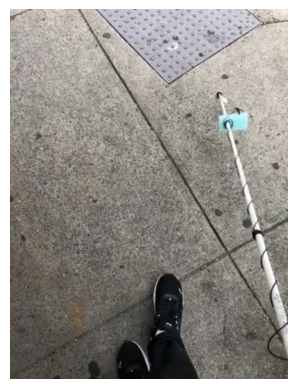

In [6]:
import cv2
import matplotlib.pyplot as plt

def get_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Cannot open video: {video_path}")
        return None

    # Jump to the very first frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("❌ Failed to read the first frame.")
        return None

    # Convert to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame_rgb

# Usage example
first_frame_img = None
if 'next_video' in globals() and next_video is not None:
    first_frame_img = get_first_frame(next_video)
    if first_frame_img is not None:
        plt.imshow(first_frame_img)
        plt.axis('off')
        plt.show()
else:
    print("No next_video variable found or it is None.")


🔍 Material change detected at frame 13 (0.43 sec) - similarity=0.30
✅ Returning frame 43 (~1.0s after change, time=1.43 sec)


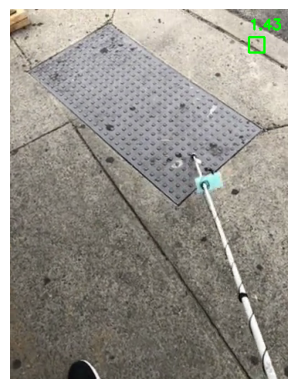

In [13]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

def detect_material_change_template(video_path, bbox, threshold=0.6, delay_seconds=1.0, fps_assumed=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Cannot open video: {video_path}")
        return None

    # Assume fps = 30 if not available
    fps = fps_assumed if fps_assumed else cap.get(cv2.CAP_PROP_FPS)
    delay_frames = int(fps * delay_seconds)

    # First frame (reference)
    ret, frame = cap.read()
    if not ret:
        cap.release()
        print("❌ Failed to read first frame.")
        return None

    x, y, w, h = map(int, bbox)
    ref_patch_gray = cv2.cvtColor(frame[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)

    frame_idx = 1
    change_detected_at = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Match reference in current frame
        res = cv2.matchTemplate(gray, ref_patch_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(res)
        tip_x, tip_y = max_loc

        # Ensure crop stays inside frame
        if (tip_x < 0 or tip_y < 0 or 
            tip_x + w > gray.shape[1] or 
            tip_y + h > gray.shape[0]):
            continue

        tip_patch_gray = gray[tip_y:tip_y+h, tip_x:tip_x+w]

        if tip_patch_gray.shape != ref_patch_gray.shape:
            continue

        similarity = ssim(ref_patch_gray, tip_patch_gray)

        if similarity < threshold and change_detected_at is None:
            change_detected_at = frame_idx
            print(f"🔍 Material change detected at frame {frame_idx} ({frame_idx/fps:.2f} sec) - similarity={similarity:.2f}")
        
        if change_detected_at is not None and frame_idx >= change_detected_at + delay_frames:
            print(f"✅ Returning frame {frame_idx} (~{delay_seconds}s after change, time={frame_idx/fps:.2f} sec)")
            cap.release()

            # Draw bounding box
            cv2.rectangle(frame, (tip_x, tip_y), (tip_x + w, tip_y + h), (0, 255, 0), 2)
            cv2.putText(frame, f"{frame_idx/fps:.2f} sec", (tip_x, tip_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    cap.release()
    print("No significant material change detected.")
    return None


# ==== Run ====
bbox = (250, 300, 20, 20)  # Adjust for cane tip in your video
changed_frame = detect_material_change_template(next_video, bbox, threshold=0.6, delay_seconds=1.0, fps_assumed=30)

if changed_frame is not None:
    plt.imshow(changed_frame)
    plt.axis('off')
    plt.show()


🔍 Material change detected at frame 13 (0.43 sec) - similarity=0.30
✅ Capturing frame 43 (~1.0s after change, time=1.43 sec)
🔍 Material change detected at frame 44 (1.47 sec) - similarity=0.38
✅ Capturing frame 74 (~1.0s after change, time=2.47 sec)
🔍 Material change detected at frame 75 (2.50 sec) - similarity=0.30
✅ Capturing frame 105 (~1.0s after change, time=3.50 sec)
🔍 Material change detected at frame 106 (3.53 sec) - similarity=0.47
✅ Capturing frame 136 (~1.0s after change, time=4.53 sec)
🔍 Material change detected at frame 137 (4.57 sec) - similarity=0.47
✅ Capturing frame 167 (~1.0s after change, time=5.57 sec)
🔍 Material change detected at frame 168 (5.60 sec) - similarity=0.29
✅ Capturing frame 198 (~1.0s after change, time=6.60 sec)
🔍 Material change detected at frame 199 (6.63 sec) - similarity=0.44
✅ Capturing frame 229 (~1.0s after change, time=7.63 sec)
🔍 Material change detected at frame 230 (7.67 sec) - similarity=0.32
✅ Capturing frame 260 (~1.0s after change, time

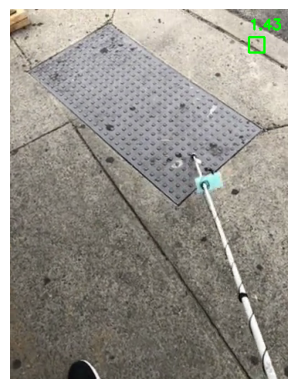

Showing frame 74


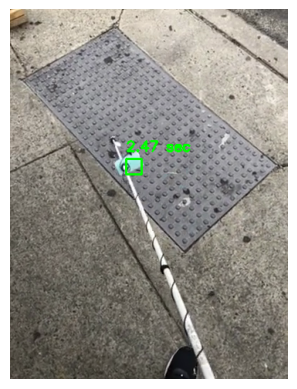

Showing frame 105


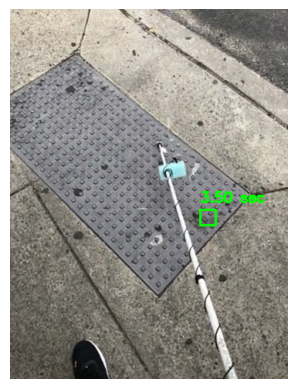

Showing frame 136


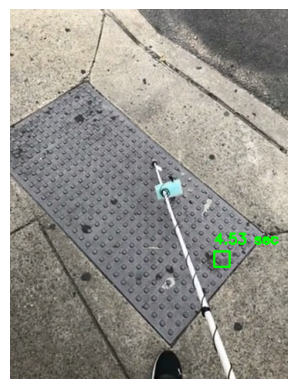

Showing frame 167


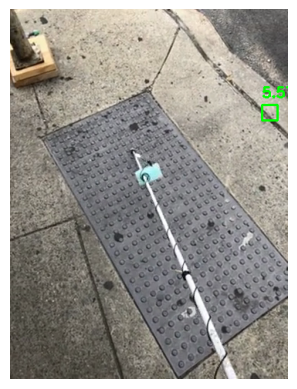

Showing frame 198


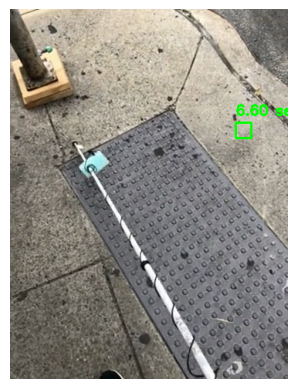

Showing frame 229


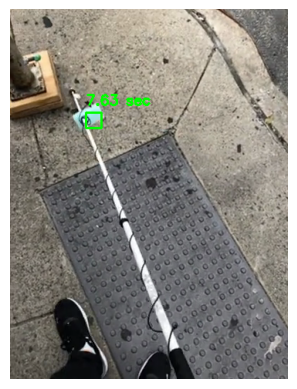

Showing frame 260


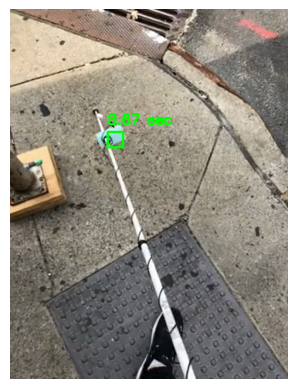

In [14]:
def detect_all_material_changes(video_path, bbox, threshold=0.6, delay_seconds=1.0, fps_assumed=30):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Cannot open video: {video_path}")
        return []

    fps = fps_assumed if fps_assumed else cap.get(cv2.CAP_PROP_FPS)
    delay_frames = int(fps * delay_seconds)

    ret, frame = cap.read()
    if not ret:
        cap.release()
        print("❌ Failed to read first frame.")
        return []

    x, y, w, h = map(int, bbox)
    ref_patch_gray = cv2.cvtColor(frame[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)

    frame_idx = 1
    changes = []  # to store (frame_idx, frame image) tuples after delay
    change_detected_at = None  # frame when last change detected
    waiting_for_delay = False

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res = cv2.matchTemplate(gray, ref_patch_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(res)
        tip_x, tip_y = max_loc

        if (tip_x < 0 or tip_y < 0 or 
            tip_x + w > gray.shape[1] or 
            tip_y + h > gray.shape[0]):
            continue

        tip_patch_gray = gray[tip_y:tip_y+h, tip_x:tip_x+w]
        if tip_patch_gray.shape != ref_patch_gray.shape:
            continue

        similarity = ssim(ref_patch_gray, tip_patch_gray)

        if not waiting_for_delay and similarity < threshold:
            change_detected_at = frame_idx
            waiting_for_delay = True
            print(f"🔍 Material change detected at frame {frame_idx} ({frame_idx/fps:.2f} sec) - similarity={similarity:.2f}")

        if waiting_for_delay and frame_idx >= change_detected_at + delay_frames:
            print(f"✅ Capturing frame {frame_idx} (~{delay_seconds}s after change, time={frame_idx/fps:.2f} sec)")
            
            # Draw bounding box and timestamp on frame copy
            frame_out = frame.copy()
            cv2.rectangle(frame_out, (tip_x, tip_y), (tip_x + w, tip_y + h), (0, 255, 0), 2)
            cv2.putText(frame_out, f"{frame_idx/fps:.2f} sec", (tip_x, tip_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
            
            changes.append( (frame_idx, cv2.cvtColor(frame_out, cv2.COLOR_BGR2RGB)) )
            waiting_for_delay = False  # reset waiting for next change

    cap.release()

    if not changes:
        print("No significant material changes detected.")
    else:
        print(f"Total {len(changes)} material changes detected.")

    return changes

# ===== Example usage =====
bbox = (250, 300, 20, 20)  # your ROI for the cane tip
all_changes = detect_all_material_changes(next_video, bbox, threshold=0.6, delay_seconds=1.0, fps_assumed=30)

for frame_idx, img in all_changes:
    print(f"Showing frame {frame_idx}")
    plt.imshow(img)
    plt.axis('off')
    plt.show()